In [1]:
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
import matplotlib.pyplot as plt
import queue
import glob
import os
import json
from PIL import Image
from shapely import wkt, geometry
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from tensorflow.python.keras.utils.data_utils import Sequence

In [33]:
SIZE_CUTS = 128              # size of the sub images extracted (in pixels)
SIZE_BUILDING_SEARCH = 32    # size of the granularity for building detection (should be smaller than SIZE_CUTS)
points_grid = [[geometry.Point(SIZE_BUILDING_SEARCH*i+SIZE_BUILDING_SEARCH//2, \
                SIZE_BUILDING_SEARCH*j+SIZE_BUILDING_SEARCH//2) \
                for j in range((2**10)//SIZE_BUILDING_SEARCH)] for i in range((2**10)//SIZE_BUILDING_SEARCH)]
all_points_grid = [[geometry.Point(i, j) for j in range(2**10)] for i in range(2**10)]


## CHANGE PATH ACCORDINGLY (all images and )
PATH_TO_DATASET = "D:\\Datasets\\2019 - Polytechnique - Hackathon Septembre\\Sujets\\XView2\\train\\"


def get_incident_list():
    '''
    output: list of events id
    '''
    return [f[:-18] for f in os.listdir(PATH_TO_DATASET) if 'post_disaster.png' in f]
incidents_id = get_incident_list()

def get_image(incident_id, post):
    '''
    inputs: incident_id (string) : nom de la photo (exemple : hurricane-florence_00000044)
            post (booléen): True pour l'image après le désastre, False pour l'image avant
    output: numpy array 1024*1024*3
    '''
    post = "_post_disaster.png" if post else "_pre_disaster.png"
    fname = PATH_TO_DATASET + incident_id + post
    return np.array(Image.open(fname))

def get_label(incident_id, post):
    '''
    inputs: incident_id (string) : nom de la photo (exemple : hurricane-florence_00000044)
            post (booléen): True pour l'image après le désastre, False pour l'image avant
    output: dictionary:
                - "features" (properties of the image):
                    list of info for each building as dictionary:
                        - "uid" (string) id of the building
                        - "wkt" (list): list of the integer coordinates of the box for the building
                        - "damage" (int): 0 to 3 or -1, refer to the classification (only for post data)
                - "metadata": dictionary with
                    - "gsd" (ground sample distance)
                    - "off_nadir_angle"
                    - "sun_azimuth"
                    - "sun_elevation"
                    - "target_azimuth"
                    - "disaster"
                    - "disaster_type"
                    - "width"
                    - "height"
    '''
    postfixe = "_post_disaster.json" if post else "_pre_disaster.json"
    with open(PATH_TO_DATASET + incident_id + postfixe) as json_file:
        data = json.load(json_file)
        
    # Filter available fields for the features
    data["features"] = data["features"]["xy"]
    for b in range(len(data["features"])):
        building = data["features"][b]
        building_filtered = {"uid": building["properties"]["uid"]}
        polygon = wkt.loads(building['wkt'])
        polygon = list(zip(polygon.exterior.coords.xy[1], polygon.exterior.coords.xy[0]))
        building_filtered["wkt"] = polygon
        if post:
            damage = {'destroyed':4, 'major-damage':3, 'minor-damage':2, 'no-damage':1, \
                      'un-classified':0}[building['properties']["subtype"]]
            building_filtered["damage"] = damage
        data["features"][b] = building_filtered
    
    # Filter available fields for the metadata
    metadataFields = ["gsd", "off_nadir_angle", "sun_aizmuth", "sun_elevation", "target_azimuth", \
                     "disaster", "disaster_type", "width", "height"]
    data["metadata"] = {k:v for k,v in data["metadata"].items() if k in metadataFields}
    
    return data



def extract_images2(incident_id, post):
    '''
    inputs: img (Image object or np.array)
            post (booléen): True pour l'image après le désastre, False pour l'image avant
    output: list of pairs (sub images, damage) (length 2**20 / sizeCut^2, each sub image has size sizeCut*sizeCut)
    '''
    img = get_image(incident_id, post)
    labels = get_label(incident_id, post)
    buildings_labels = []
    for b in labels["features"]:
        if post:
            buildings_labels.append((b["wkt"], b["damage"]))
        else:
            buildings_labels.append((b["wkt"], 1))    
    
    # Detection of buildings
    number_division = 2**10//SIZE_BUILDING_SEARCH
    buildings_array = np.zeros((number_division, number_division))
    for coordinates,l in buildings_labels :
        for x,y in coordinates :
            i,j =int(x // SIZE_BUILDING_SEARCH), int(y // SIZE_BUILDING_SEARCH)
            i,j = max(i,0), max(j,0)
            i,j = min(i,number_division-1),min(j,number_division-1)
            buildings_array[i,j] = 1
    # Extract subimages containing buildings
    subImages = []
    fact = SIZE_CUTS//SIZE_BUILDING_SEARCH
    for i in range(2**10 // SIZE_CUTS):
        for j in range(2**10 // SIZE_CUTS):
            subImages.append((img[i*SIZE_CUTS:(i+1)*SIZE_CUTS, j*SIZE_CUTS:(j+1)*SIZE_CUTS], 
                              buildings_array[i*fact:(i+1)*fact, j*fact:(j+1)*fact]))
    return subImages


In [37]:
def label_image(incident_id, post):
    '''
    inputs: img (Image object or np.array)
            post (booléen): True pour l'image après le désastre, False pour l'image avant
    output: np.array with size 1024*1024*5, the third dimension giving the classes
    '''
    img = get_image(incident_id, post)
    labels = get_label(incident_id, post)
    buildings_labels = []
    for b in labels["features"]:
        if post:
            buildings_labels.append((geometry.Polygon(b["wkt"]), b["damage"]))
        else:
            buildings_labels.append((geometry.Polygon(b["wkt"]), 1)) 
    labeled_img = np.zeros((1024,1024,5))
    for i in range(1024):
        for j in range(1024):
            noBuilding = True
            for b in buildings_labels:
                if b[0].contains(all_points_grid[i][j]):
                    labeled_img[i, j][b[1]] = 1
                    noBuilding = False
                    break
                if noBuilding:
                    labeled_img[i, j][0] = 1
    return labeled_img

In [738]:
class Dataset_generator(Sequence) :
    def __init__(self, ids, batch_size=16):
        self.ids = ids
        self.im_index = 0
        self.batch_size = batch_size
        self.sub_image_queue = queue.Queue()
        self.steps_per_epoch = (((1024//SIZE_CUTS)**2) * len(ids) ) // batch_size
    def get_next_images(self) :
        for data in extract_images(self.ids[self.im_index], False):
            self.sub_image_queue.put(data)
        self.im_index = (self.im_index + 1) % len(self.ids)
    def __len__(self) :
        return self.steps_per_epoch
    def __getitem__(self, idx):
        x = []
        y = []
        for i in range(self.batch_size) :
            if self.sub_image_queue.empty():
                self.get_next_images()
            image,label = self.sub_image_queue.get()
            x.append(image)
            y.append(label)
        return np.array(x), np.array(y) ,  np.max(np.max(np.array(y),axis=1), axis=1)*50+0.5

In [739]:
pretrained_model =  keras.applications.MobileNet(include_top=False, input_shape=(SIZE_CUTS,SIZE_CUTS,3))
pretrained_model.trainable = False

In [772]:
model = keras.Sequential()
model.add(pretrained_model)
model.add(keras.layers.Dense(1024, activation="relu"))
model.add(keras.layers.GaussianNoise(1))
model.add(keras.layers.Dense(1, activation="sigmoid"))
model.add(keras.layers.Reshape((4,4)))
#model.add(keras.layers.MaxPooling2D(pool_size=(4, 4)))

In [773]:
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [774]:
incidents_id = get_incident_list()
batch_size = 16

In [775]:
train_gen = Dataset_generator(incidents_id[:-20])
test_gen = Dataset_generator(incidents_id[-20:])
model.fit_generator(train_gen, steps_per_epoch=train_gen.steps_per_epoch, epochs=20, validation_data=test_gen, 
                    validation_steps=test_gen.steps_per_epoch)

Epoch 1/20
400/400 [==============================] - 21s 53ms/step - loss: 9.0298 - acc: 0.8773 - val_loss: 7.2123 - val_acc: 0.9267
Epoch 2/20
400/400 [==============================] - 10s 24ms/step - loss: 4.8962 - acc: 0.9210 - val_loss: 7.5986 - val_acc: 0.9270
Epoch 3/20
400/400 [==============================] - 10s 26ms/step - loss: 4.1397 - acc: 0.9255 - val_loss: 8.7662 - val_acc: 0.9274
Epoch 4/20
400/400 [==============================] - 10s 26ms/step - loss: 3.5014 - acc: 0.9239 - val_loss: 9.8231 - val_acc: 0.9276
Epoch 5/20
400/400 [==============================] - 10s 24ms/step - loss: 2.9157 - acc: 0.9348 - val_loss: 11.1069 - val_acc: 0.9277
Epoch 6/20
400/400 [==============================] - 10s 25ms/step - loss: 2.4121 - acc: 0.9433 - val_loss: 10.2372 - val_acc: 0.9002
Epoch 7/20
400/400 [==============================] - 10s 24ms/step - loss: 2.0840 - acc: 0.9382 - val_loss: 14.5327 - val_acc: 0.9287
Epoch 8/20
400/400 [==============================] - 10s 2

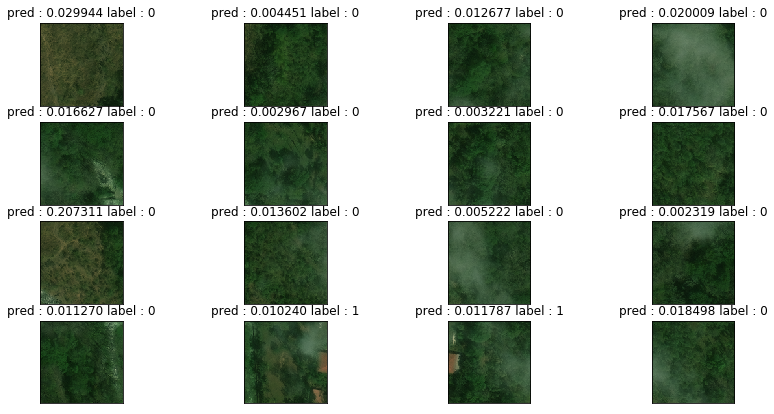

In [745]:
input_data = train_gen[0]
pred = model.predict(input_data[0])
pred = np.mean(pred, axis=1)
pred = np.mean(pred, axis=1)
label = input_data[1]
label = np.max(label, axis=1)
label = np.max(label, axis=1)
f, axarr = plt.subplots(4,4, figsize=(14, 7))
for i in range(4) :
    for j in range(4) :
        axarr[j,i].imshow(input_data[0][i+4*j])
        axarr[j,i].axes.get_xaxis().set_visible(False)      
        axarr[j,i].axes.get_yaxis().set_visible(False)
        axarr[j,i].set_title("pred : %f label : %d" % (pred[i+4*j], label[i+4*j]))

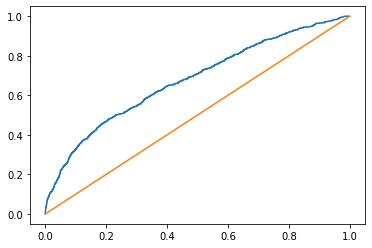

In [776]:
from sklearn.metrics import roc_curve

total_label = []
total_pred = []
for i in range(len(test_gen)):
    input_data = train_gen[0]
    pred = model.predict(input_data[0])
    label = input_data[1]
    total_pred.append(pred)
    total_label.append(label)
    
total_pred = np.array(total_pred)
total_label = np.array(total_label)

total_pred = total_pred.flatten()
total_label = total_label.flatten()

fpr, tpr, thresholds = roc_curve(total_label, total_pred)

plt.plot(fpr, tpr, label="ROC curve")
plt.plot(fpr, fpr)
